1. [Import and Ingest data in Quantopian Zipline](#Import-and-ingest-data-in-Quantopian-Zipline)

1. [Time Series Analysis](#Time-Series-Analysis)

1. [Feature's Engineering](#Feature's-Engineering)
    1. [Technical Analysis](#Technical-Analysis)
    1. [Fundamental Analysis](#Fundamental-Analysis)
    1. [Sentiment Analysis](#Sentiment-Analysis)

1. [Model Prediction](#Model-Prediction)
    1. [Linear Model](#Linear-Model)
    1. [GARCH Model](#GARCH-Model) 
    1. [Decision Trees and Random Forests](#Decision-Trees-and-Random-Forests) 
    1. [Gradient Boosting and Adaboost Models](#Gradient-Boosting-and-Adaboost-Models)
    1. [K-Neighbors](#K-Neighbors) 
    1. [Neural Networks](#Neural-Networks)
    1. [Deep Learning and LSTM](#Deep-Learning-and-LSTM)   

# Import and ingest data in Quantopian Zipline
<div style = "float:right"><a style="text-decoration:none" href = "#inicio">Inicio</a></div>

## Import data from Yahoo Financials

In [1]:
# Load IPython Magic
%load_ext watermark
%load_ext zipline

In [2]:
# Import Libraries
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import zipline
from yahoofinancials import YahooFinancials
import warnings


# Default working directory
# os.chdir("../data")

# Display maximum columns
pd.set_option('display.max_columns', None)

# Seaborn graphic style as default
plt.style.use('seaborn')
# Graphics default size
plt.rcParams['figure.figsize'] = [16, 9]
plt.rcParams['figure.dpi'] = 200

# Warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
%watermark --iversions

pandas  0.22.0
zipline 1.4.0
numpy   1.14.2



We will download our stock series from Yahoo Financials in an Zipline accepted format, namely OHLC, volume, dividend and split, following this [article](https://medium.com/inside-bux/introduction-to-backtesting-trading-strategies-da152be3e6e0).

In [13]:
def download_csv_data(ticker, start_date, end_date, freq, path):
    yahoo_financials = YahooFinancials(ticker)

    df = yahoo_financials.get_historical_price_data(start_date, end_date, freq)
    df = pd.DataFrame(df[ticker]['prices']).drop(['date'], axis=1) \
             .rename(columns={'formatted_date': 'date'}) \
             .loc[:, ['date', 'open', 'high', 'low', 'close', 'volume']] \
             .set_index('date')
    df.index = pd.to_datetime(df.index)
    df['dividend'] = 0
    df['split'] = 1

    # save data to csv for later ingestion
    df.to_csv(path, header=True, index=True)

    # plot the time series
    df.close.plot(title='{} prices --- {}:{}'.format(ticker, start_date, end_date));

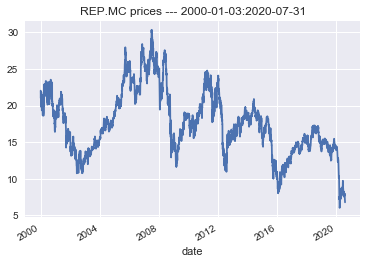

In [15]:
download_csv_data(ticker='REP.MC', 
                  start_date='2000-01-03', 
                  end_date='2020-07-31', 
                  freq='daily', 
                  path='../data/OHLCV/REP.csv')

## Ingest custom data bundle from a csv file in Quantopian Zipline

**In a Zipline environment, we need to (i) create a bundle and (ii) ingest it.** <br>

A bundle is an interface to import data into Zipline. Zipline stores data in its own preferred format. The library is able to read data incrementally, and only holds a part of the data in its memory at any given time. The bundle is then the interface, which reads data source and hands it over to Zipline for processing and storage. <br>
Ingest is the process of reading data with the help of a bundle, and storing it in Zipline's format. <br>

Zipline comes ready with data downloaded from Quandl (the WIKI database). However, in mid-2018 the data was discontinued. Furthermore, Quandl dataset only covers US stocks. For that reason, we shall create our own bundle with IBEX35 stocks and ingest it manually. <br>

Ingesting custom data bundle from a csv file is complicated and is not well explained in the documentation. The following book [Trading Evolved by Andreas Clenow](https://www.amazon.es/Trading-Evolved-Anyone-Killer-Strategies/dp/109198378X/ref=sr_1_1?adgrpid=68481793911&dchild=1&gclid=EAIaIQobChMI5JqUgsiJ6wIVCLrtCh1eAwH-EAAYASAAEgIAEPD_BwE&hvadid=327706962187&hvdev=c&hvlocphy=1005499&hvnetw=g&hvqmt=e&hvrand=5186505841026467309&hvtargid=kwd-801233091056&hydadcr=1948_1738136&keywords=trading+evolved&qid=1596819455&sr=8-1&tag=hydes-21) (chapter 23: Importing your Data) provides guidance for the task. <br>

<ol>
    <li>Create the bundle</li>
First, we need to write a Python script (renamed after the name of our bundle) located in the bundles folder of our Zipline library containing (i) a specific function signature, (ii) a generator function, which will iterate over our stocks, process the data and populate the DataFrames we need and (iii) a dividends function checking for dividends, if any. <br>
Second, we shall register the bundle with Zipline and create an extension.py file in the '/.zipline' folder. <br>
    
   <li>Ingest the bundle</li>
Finally, we ingest the bundle in our Jupyter Notebook (see below).
<ol/>

In [9]:
from zipline.utils.calendars import get_calendar
import pandas as pd
from collections import OrderedDict
import pytz
import glob
import os

from_file_path = "/home/isabel/Repos/ml_for_algo_trading/data/OHLCV/*.csv"
to_file_path = "/home/isabel/Repos/ml_for_algo_trading/data/OHLCV/"
start_date = "2000-01-03"
end_date = "2020-07-31"

for fname in glob.glob(from_file_path):
    destination_file = to_file_path + os.path.basename(fname)
    print("Adding missing dates to {} and copying to {}".format(os.path.basename(fname),destination_file))

    df = pd.read_csv(fname, index_col=0, parse_dates=True, sep=",", header=0)
    df.index.name = 'date'

    # Ensure the df is indexed by UTC timestamps
    
    df = df.set_index(df.index.to_datetime().tz_localize('UTC'))

    # Get all expected trading sessions in this range and reindex.
    sessions = get_calendar('XMAD').sessions_in_range(start_date, end_date)
    df = df.reindex(sessions)
    df.to_csv(destination_file)

    print("Finished")

Adding missing dates to REP.csv and copying to /home/isabel/Repos/ml_for_algo_trading/data/OHLCV/REP.csv
Finished


In [11]:
# ingest our custom bundle: ibex35_stock_data
!zipline ingest --bundle ibex35_stock_data

[2020-08-10 14:22:26.484090] INFO: zipline.data.bundles.core: Ingesting ibex35_stock_data.
Loading REP...
Traceback (most recent call last):
  File "/home/isabel/anaconda3/envs/ml_for_algo_trading/bin/zipline", line 11, in <module>
    load_entry_point('zipline==1.4.0', 'console_scripts', 'zipline')()
  File "/home/isabel/anaconda3/envs/ml_for_algo_trading/lib/python3.5/site-packages/click/core.py", line 829, in __call__
    return self.main(*args, **kwargs)
  File "/home/isabel/anaconda3/envs/ml_for_algo_trading/lib/python3.5/site-packages/click/core.py", line 782, in main
    rv = self.invoke(ctx)
  File "/home/isabel/anaconda3/envs/ml_for_algo_trading/lib/python3.5/site-packages/click/core.py", line 1259, in invoke
    return _process_result(sub_ctx.command.invoke(sub_ctx))
  File "/home/isabel/anaconda3/envs/ml_for_algo_trading/lib/python3.5/site-packages/click/core.py", line 1066, in invoke
    return ctx.invoke(self.callback, **ctx.params)
  File "/home/isabel/anaconda3/envs/ml_f

In [13]:
!zipline bundles

csvdir <no ingestions>
ibex35_stock_data 2020-08-07 16:40:30.271346
quandl <no ingestions>
quantopian-quandl <no ingestions>


## Load data bundle

We will now proceed with loading our bundle. For such purpose, the [video](https://subscription.packtpub.com/video/application_development/9781789951165) <i>Machine Learning for Algorithmic Trading Bots in Python</i> by Mustafa Qamar-ud-Din, has been of great help. Therefore, we will first import necessary libraries.<br>
In order to help Zipline find our custom bundle, we will additionally load extensions in the IPython magic. Check this [GitHub thread](https://github.com/quantopian/zipline/issues/1542)for more information.<br>
On how to proceed with this section, this other [GitHub thread](https://github.com/quantopian/zipline/issues/1579) might also be worth exploring.

In [14]:
from zipline.data.data_portal import DataPortal
from zipline.data import bundles
from zipline.utils.calendars import get_calendar

import os

from zipline.utils.run_algo import load_extensions

load_extensions(
    default=True,
    extensions=[],
    strict=True,
    environ=os.environ,
)

First, let's load our bundle

In [15]:
bundle_data = bundles.load('ibex35_stock_data')

In [16]:
print(type(bundle_data))

<class 'zipline.data.bundles.core.BundleData'>


Second, we initialise our DataPortal interface with the below mandatory arguments.
We shall beforehand define our end_date argument and check for the first trading day.

In [17]:
end_date = pd.Timestamp("2020-07-31", tz="utc")

In [18]:
bundle_data.equity_daily_bar_reader.first_trading_day

Timestamp('2000-01-03 00:00:00+0000', tz='UTC')

In [19]:
data_por = DataPortal(
    asset_finder=bundle_data.asset_finder,
    trading_calendar=get_calendar("XMAD"),
    first_trading_day=bundle_data.equity_daily_bar_reader.first_trading_day,
    equity_daily_reader=bundle_data.equity_daily_bar_reader
)

Third, we will build our DataFrame for further analysis and feature preprocessing. For such purpose, we shall use a get_history_window method on the data portal interface.

In [20]:
REP = data_por.asset_finder.lookup_symbol(
    'REP',
    as_of_date=None
)

In [21]:
df = data_por.get_history_window(
    assets=[REP],
    end_dt=end_date,
    bar_count=5226,
    frequency='1d',
    data_frequency='daily',
    field='close'
)

In [26]:
df.tail()

,REP
2020-07-27 00:00:00+00:00,7.162
2020-07-28 00:00:00+00:00,7.062
2020-07-29 00:00:00+00:00,7.036
2020-07-30 00:00:00+00:00,6.788
2020-07-31 00:00:00+00:00,6.788


We now index our date column and rename the stock column after the ticker's name.

In [27]:
df.index = pd.DatetimeIndex(df.index)

The name of the column <i>Equity(0 [REP])</i> is a Pandas object (more concretely, a 'zipline.assets._assets.Equity' object). When we attempt to rename it, a TypeError is displayed (Index does not support mutable operations). As such, we will create another identical column thus passing a list method to the column name and then drop the original column.

In [24]:
df['REP'] = df[list(df.columns)[0]]

In [25]:
df = df.drop(columns=[list(df.columns)[0]])
df.head()

,REP
2000-01-03 00:00:00+00:00,22.04
2000-01-04 00:00:00+00:00,21.30
2000-01-05 00:00:00+00:00,21.01
2000-01-07 00:00:00+00:00,21.67
2000-01-10 00:00:00+00:00,21.90
